In [2]:
import learn2learn as l2l
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import sys
import argparse
import os
from run_MAML_04 import test2 as test_maml


sys.path.insert(1, "..")

from ts_dataset import TSDataset
from base_models import LSTMModel, FCN
from metrics import torch_mae as mae
import copy
from pytorchtools import EarlyStopping
from eval_base_models import test, train, freeze_model
from torch.utils.data import Dataset, DataLoader
from ts_dataset import DomainTSDataset, SimpleDataset

## Fine-tuning MAML vs LSTM

In [3]:
meta_info = {"POLLUTION": [5, 50, 14],
             "HR": [32, 50, 13],
             "BATTERY": [20, 50, 3] }




output_directory = "output/"
horizon = 10
output_dim = 1

dataset_name = "HR"
save_model_file = "model.pt"
load_model_file = "model.pt"
lower_trial = 0
upper_trial = 3
learning_rate = 0.01
meta_learning_rate = 0.005
adaptation_steps = 10
batch_size = 20
model_name = "LSTM"
is_test = 1
patience_stopping = 20
epochs = 1000
noise_level = 0.0
noise_type = "additive"

params = {'batch_size': batch_size,
      'shuffle': True,
      'num_workers': 0}

assert model_name in ("FCN", "LSTM"), "Model was not correctly specified"
assert dataset_name in ("POLLUTION", "HR", "BATTERY")

window_size, task_size, input_dim = meta_info[dataset_name]
grid = [0., noise_level]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )

In [ ]:
trial = 0
output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"

save_model_file_ = output_directory + "encoder_"+save_model_file
save_model_file_2 = output_directory + save_model_file
load_model_file_ = output_directory + load_model_file

model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
model2 = nn.Linear(120, 1)

model.cuda()
model2.cuda()

maml = l2l.algorithms.MAML(model2, lr=learning_rate, first_order=False)
model.load_state_dict(torch.load(save_model_file_))
maml.load_state_dict(torch.load(save_model_file_2))

loss_hist =[]
for i in range(20):
    loss = test_maml(maml, model, model_name, dataset_name, test_data_ML, 1, learning_rate,0, noise_type, horizon =i)
    print(loss.cpu().numpy())
    loss_hist.append(float(loss.cpu().numpy()))

In [ ]:

total_tasks_test = len(test_data_ML)
error_list =  []
parameters_list = []
domain_list = []

learner = maml.clone()  # Creates a clone of model
learner.cuda()
accum_error = 0.0
accum_std = 0.0
count = 0.0
grid = [0., noise_level]

input_dim = test_data_ML.x.shape[-1]
window_size = test_data_ML.x.shape[-2]
output_dim = test_data_ML.y.shape[-1]

if is_test:
    step = total_tasks_test//100

else:
    step = 1

step = 1 if step == 0 else step

for task in range(0, (total_tasks_test-horizon-1), step):

    temp_file_idx = test_data_ML.file_idx[task:task+horizon+1]
    if(len(np.unique(temp_file_idx))>1):
        continue

    if model_name == "LSTM":
        model2 = LSTMModel( batch_size=None, seq_len = None, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
    elif model_name == "FCN":
        kernels = [8,5,3] if window_size != 5 else [4,2,1]
        model2 = FCN(time_steps = window_size,  channels=[input_dim, 128, 128, 128] , kernels=kernels)


    #model2.cuda()
    #model2.load_state_dict(copy.deepcopy(maml.module.state_dict()))
    #opt2 = optim.Adam(model2.parameters(), lr=learning_rate)
    learner = maml.clone() 

    x_spt, y_spt = test_data_ML[task]
    x_qry = test_data_ML.x[(task+1):(task+1+horizon)].reshape(-1, window_size, input_dim)
    y_qry = test_data_ML.y[(task+1):(task+1+horizon)].reshape(-1, output_dim)
    #x_qry = test_data_ML.x[(task+1)].reshape(-1, window_size, input_dim)
    #y_qry = test_data_ML.y[(task+1)].reshape(-1, output_dim)

    if model_name == "FCN":
        x_qry = np.transpose(x_qry, [0,2,1])
        x_spt = np.transpose(x_spt, [0,2,1])

    x_spt, y_spt = to_torch(x_spt), to_torch(y_spt)
    x_qry = to_torch(x_qry)
    y_qry = to_torch(y_qry)


    epsilon = grid[np.random.randint(0,len(grid))]

    if noise_type == "additive":
        y_spt = y_spt+epsilon
        y_qry = y_qry+epsilon

    else:
        y_spt = y_spt*(1+epsilon)
        y_qry = y_qry*(1+epsilon)


    #learner.module.train()
    #model2.eval()
    for step in range(adaptation_steps):

        #model2.train()
        pred = learner(model.encoder(x_spt))
        error = mae(pred, y_spt)

        #opt2.zero_grad()
        #error.backward()

        learner.adapt(error)
        #opt2.step()

    


    print("std:", accum_std/count)

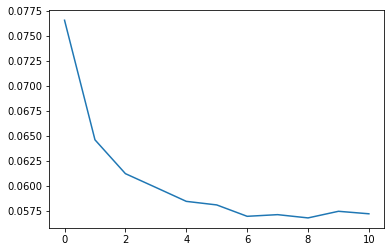

In [33]:
import matplotlib.pyplot as plt
plt.plot(loss_hist)

In [19]:
trial = 2
output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MAML/"+str(trial)+"/"

save_model_file_ = output_directory + "encoder_"+save_model_file
save_model_file_2 = output_directory + save_model_file
load_model_file_ = output_directory + load_model_file

model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
model2 = nn.Linear(120, 1)

model.cuda()
model2.cuda()

maml = l2l.algorithms.MAML(model2, lr=learning_rate, first_order=False)
model.load_state_dict(torch.load(save_model_file_))
maml.load_state_dict(torch.load(save_model_file_2))

for i in range(10):
    loss = test_maml(maml, model, model_name, dataset_name, test_data_ML, i, learning_rate,0, noise_type)
    print(loss.cpu().numpy())

0.04197604
0.041967083
0.041958276
0.041949566
0.04194093
0.041932367
0.04192387


KeyboardInterrupt: 

In [20]:
output_directory_nomaml = "../../Models/"+dataset_name+"_"+model_name+"/"+str(trial)+"/"
save_model_file_nomaml = output_directory_nomaml + "temp_model.pt"
load_model_file_nomaml = output_directory_nomaml + "model.pt"

In [40]:
n_tasks, task_size, dim, channels = test_data_ML.x.shape if is_test else validation_data_ML.x.shape
horizon = 10
freeze_model_flag = True
test_loss_list1 = []
test_loss_list2 = []
initial_test_loss_list1 = []
initial_test_loss_list2 = []
regularization_penalty = 0.0

def test_nomaml(epochs):

    verbose = 0
    if n_tasks == 50:
        step = n_tasks//100
    else:
        step = 1

    for task_id in range(0, (n_tasks-horizon-1), step):


        #check that all files blong to the same domain
        temp_file_idx = test_data_ML.file_idx[task_id:task_id+horizon+1] if is_test else validation_data_ML.file_idx[task_id:task_id+horizon+1]
        if(len(np.unique(temp_file_idx))>1):
            continue

        if is_test: 
            temp_x_train = test_data_ML.x[task_id]
            temp_y_train = test_data_ML.y[task_id]

            temp_x_test1 = test_data_ML.x[(task_id+1):(task_id+horizon+1)].reshape(-1, dim, channels)
            temp_y_test1 = test_data_ML.y[(task_id+1):(task_id+horizon+1)].reshape(-1, 1)

            temp_x_test2 = test_data_ML.x[(task_id+1)].reshape(-1, dim, channels)
            temp_y_test2 = test_data_ML.y[(task_id+1)].reshape(-1, 1)

        else:
            temp_x_train = validation_data_ML.x[task_id]
            temp_y_train = validation_data_ML.y[task_id]

            temp_x_test1 = validation_data_ML.x[(task_id+1):(task_id+horizon+1)].reshape(-1, dim, channels)
            temp_y_test1 = validation_data_ML.y[(task_id+1):(task_id+horizon+1)].reshape(-1, 1)

            temp_x_test2 = validation_data_ML.x[(task_id+1)].reshape(-1, dim, channels)
            temp_y_test2 = validation_data_ML.y[(task_id+1)].reshape(-1, 1)


        if model_name == "FCN":

            kernels = [8,5,3] if dataset_name!= "POLLUTION" else [4,2,1]
            temp_x_train = np.transpose(temp_x_train, [0,2,1])
            temp_x_test1 = np.transpose(temp_x_test1, [0,2,1])
            temp_x_test2 = np.transpose(temp_x_test2, [0,2,1])
            #temp_x_val = np.transpose(temp_x_val, [0,2,1])

        early_stopping = EarlyStopping(patience=patience_stopping, model_file=save_model_file_nomaml, verbose=verbose)


        if model_name == "LSTM":
            model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
        elif model_name == "FCN":
            model = FCN(time_steps = window_size, channels=[input_dim, 128, 128, 128], kernels=kernels )


        model.load_state_dict(torch.load(load_model_file_nomaml))


        train_loader = DataLoader(SimpleDataset(x=temp_x_train, y=temp_y_train), **params)
        test_loader1 = DataLoader(SimpleDataset(x=temp_x_test1, y=temp_y_test1), **params)
        test_loader2 = DataLoader(SimpleDataset(x=temp_x_test2, y=temp_y_test2), **params)

        verbose = False

        model.cuda()
        initial_loss1 = test(model, test_loader1, output_directory, load_model_file_nomaml, verbose)
        initial_loss2 = test(model, test_loader2, output_directory, load_model_file_nomaml, verbose)

        if freeze_model_flag:
            freeze_model(model)


        #early_stopping(initial_loss, model)
        train(model, train_loader, test_loader1, early_stopping, learning_rate, epochs, regularization_penalty) 
        early_stopping(0.0, model)
        loss1 = test(model, test_loader1, output_directory, save_model_file_, verbose)
        loss2 = test(model, test_loader2, output_directory, save_model_file_, verbose)
        print(loss1)

        test_loss_list1.append(loss1)
        initial_test_loss_list1.append(initial_loss1)
        test_loss_list2.append(loss2)
        initial_test_loss_list2.append(initial_loss2)

    return test_loss_list1, test_loss_list2, initial_test_loss_list1, initial_test_loss_list2

In [ ]:
loss_hist_2 = []
loss_hist_1 = []

for i in range(1,10):
    a, b, c, d = test_nomaml(i)
    loss_hist_1.append(np.mean(a))
    loss_hist_2.append(np.mean(b))
    

Regression error on test: 0.144789
Regression error on test: 0.204599
epoch: 0, 
 TRAINING -> mean_err: 0.093888
epoch: 0, 
 VAL -> mean_err: 0.124488
done
Regression error on test: 0.131772
Regression error on test: 0.042639
0.13177210092544556
Regression error on test: 0.145688
Regression error on test: 0.150315
epoch: 0, 
 TRAINING -> mean_err: 0.193621
epoch: 0, 
 VAL -> mean_err: 0.122633
done
Regression error on test: 0.184600
Regression error on test: 0.093331
0.18459990620613098
Regression error on test: 0.136736
Regression error on test: 0.169615
epoch: 0, 
 TRAINING -> mean_err: 0.139395
epoch: 0, 
 VAL -> mean_err: 0.118164
done
Regression error on test: 0.207958
Regression error on test: 0.063799
0.207957923412323
Regression error on test: 0.127920
Regression error on test: 0.141182
epoch: 0, 
 TRAINING -> mean_err: 0.158886
epoch: 0, 
 VAL -> mean_err: 0.117124
done
Regression error on test: 0.242952
Regression error on test: 0.084222
0.24295160174369812
Regression error o

Regression error on test: 0.300012
Regression error on test: 0.410703
0.30001190304756165
Regression error on test: 0.091859
Regression error on test: 0.086125
epoch: 0, 
 TRAINING -> mean_err: 0.075749
epoch: 0, 
 VAL -> mean_err: 0.104908
done
Regression error on test: 0.280656
Regression error on test: 0.445463
0.28065648674964905
Regression error on test: 0.087546
Regression error on test: 0.034208
epoch: 0, 
 TRAINING -> mean_err: 0.078217
epoch: 0, 
 VAL -> mean_err: 0.108398
done
Regression error on test: 0.260831
Regression error on test: 0.324671
0.2608312964439392
Regression error on test: 0.087788
Regression error on test: 0.077753
epoch: 0, 
 TRAINING -> mean_err: 0.031500
epoch: 0, 
 VAL -> mean_err: 0.081773
done
Regression error on test: 0.252245
Regression error on test: 0.424047
0.2522452473640442
Regression error on test: 0.083151
Regression error on test: 0.036989
epoch: 0, 
 TRAINING -> mean_err: 0.063323
epoch: 0, 
 VAL -> mean_err: 0.114078
done
Regression error o

Regression error on test: 0.225170
Regression error on test: 0.217046
0.22517023980617523
Regression error on test: 0.058599
Regression error on test: 0.032868
epoch: 0, 
 TRAINING -> mean_err: 0.037153
epoch: 0, 
 VAL -> mean_err: 0.038903
done
Regression error on test: 0.226957
Regression error on test: 0.237166
0.22695666551589966
Regression error on test: 0.063042
Regression error on test: 0.039700
epoch: 0, 
 TRAINING -> mean_err: 0.030360
epoch: 0, 
 VAL -> mean_err: 0.051527
done
Regression error on test: 0.226117
Regression error on test: 0.238570
0.22611671686172485
Regression error on test: 0.066996
Regression error on test: 0.045533
epoch: 0, 
 TRAINING -> mean_err: 0.036640
epoch: 0, 
 VAL -> mean_err: 0.055528
done
Regression error on test: 0.236251
Regression error on test: 0.224290
0.23625054955482483
Regression error on test: 0.069430
Regression error on test: 0.038743
epoch: 0, 
 TRAINING -> mean_err: 0.035793
epoch: 0, 
 VAL -> mean_err: 0.050562
done
Regression error

Regression error on test: 0.057997
Regression error on test: 0.057566
epoch: 0, 
 TRAINING -> mean_err: 0.058244
epoch: 0, 
 VAL -> mean_err: 0.044980
done
Regression error on test: 0.216129
Regression error on test: 0.165961
0.21612942218780518
Regression error on test: 0.073794
Regression error on test: 0.059231
epoch: 0, 
 TRAINING -> mean_err: 0.046751
epoch: 0, 
 VAL -> mean_err: 0.058128
done
Regression error on test: 0.254908
Regression error on test: 0.158954
0.2549077868461609
Regression error on test: 0.071745
Regression error on test: 0.057058
epoch: 0, 
 TRAINING -> mean_err: 0.048492
epoch: 0, 
 VAL -> mean_err: 0.059070
done
Regression error on test: 0.270274
Regression error on test: 0.161945
0.2702735364437103
Regression error on test: 0.082382
Regression error on test: 0.054173
epoch: 0, 
 TRAINING -> mean_err: 0.046962
epoch: 0, 
 VAL -> mean_err: 0.077616
done
Regression error on test: 0.305084
Regression error on test: 0.160258
0.3050840198993683
Regression error on

Regression error on test: 0.146084
Regression error on test: 0.117721
epoch: 0, 
 TRAINING -> mean_err: 0.161846
epoch: 0, 
 VAL -> mean_err: 0.073045
done
Regression error on test: 0.224565
Regression error on test: 0.283723
0.2245648056268692
Regression error on test: 0.156430
Regression error on test: 0.111636
epoch: 0, 
 TRAINING -> mean_err: 0.096858
epoch: 0, 
 VAL -> mean_err: 0.085897
done
Regression error on test: 0.213813
Regression error on test: 0.289904
0.21381281316280365
Regression error on test: 0.164548
Regression error on test: 0.111461
epoch: 0, 
 TRAINING -> mean_err: 0.091097
epoch: 0, 
 VAL -> mean_err: 0.094433
done
Regression error on test: 0.202130
Regression error on test: 0.274158
0.2021297663450241
Regression error on test: 0.168545
Regression error on test: 0.096564
epoch: 0, 
 TRAINING -> mean_err: 0.091856
epoch: 0, 
 VAL -> mean_err: 0.100633
done
Regression error on test: 0.195746
Regression error on test: 0.296661
0.1957460641860962
Regression error on

Regression error on test: 0.301342
Regression error on test: 0.300569
0.30134153366088867
Regression error on test: 0.080070
Regression error on test: 0.076535
epoch: 0, 
 TRAINING -> mean_err: 0.052868
epoch: 0, 
 VAL -> mean_err: 0.050650
done
Regression error on test: 0.307600
Regression error on test: 0.308756
0.3075996935367584
Regression error on test: 0.077504
Regression error on test: 0.076955
epoch: 0, 
 TRAINING -> mean_err: 0.065484
epoch: 0, 
 VAL -> mean_err: 0.042787
done
Regression error on test: 0.315123
Regression error on test: 0.309754
0.31512340903282166
Regression error on test: 0.077705
Regression error on test: 0.079229
epoch: 0, 
 TRAINING -> mean_err: 0.065908
epoch: 0, 
 VAL -> mean_err: 0.047445
done
Regression error on test: 0.314961
Regression error on test: 0.313785
0.3149605095386505
Regression error on test: 0.077502
Regression error on test: 0.099462
epoch: 0, 
 TRAINING -> mean_err: 0.069845
epoch: 0, 
 VAL -> mean_err: 0.055856
done
Regression error o

Regression error on test: 0.229031
Regression error on test: 0.070183
0.22903060913085938
Regression error on test: 0.117865
Regression error on test: 0.118753
epoch: 0, 
 TRAINING -> mean_err: 0.107160
epoch: 0, 
 VAL -> mean_err: 0.116506
done
Regression error on test: 0.269985
Regression error on test: 0.080901
0.2699846029281616
Regression error on test: 0.125451
Regression error on test: 0.114937
epoch: 0, 
 TRAINING -> mean_err: 0.108321
epoch: 0, 
 VAL -> mean_err: 0.132008
done
Regression error on test: 0.301020
Regression error on test: 0.084510
0.30101990699768066
Regression error on test: 0.116219
Regression error on test: 0.108688
epoch: 0, 
 TRAINING -> mean_err: 0.104469
epoch: 0, 
 VAL -> mean_err: 0.126925
done
Regression error on test: 0.318761
Regression error on test: 0.090517
0.3187609910964966
Regression error on test: 0.109202
Regression error on test: 0.078587
epoch: 0, 
 TRAINING -> mean_err: 0.098210
epoch: 0, 
 VAL -> mean_err: 0.126011
done
Regression error o

Regression error on test: 0.072278
Regression error on test: 0.025673
epoch: 0, 
 TRAINING -> mean_err: 0.030018
epoch: 0, 
 VAL -> mean_err: 0.048614
done
Regression error on test: 0.166541
Regression error on test: 0.182052
0.16654106974601746
Regression error on test: 0.074156
Regression error on test: 0.087569
epoch: 0, 
 TRAINING -> mean_err: 0.022876
epoch: 0, 
 VAL -> mean_err: 0.054772
done
Regression error on test: 0.177487
Regression error on test: 0.153690
0.1774866282939911
Regression error on test: 0.070530
Regression error on test: 0.046570
epoch: 0, 
 TRAINING -> mean_err: 0.076533
epoch: 0, 
 VAL -> mean_err: 0.036155
done
Regression error on test: 0.189271
Regression error on test: 0.168851
0.18927137553691864
Regression error on test: 0.069459
Regression error on test: 0.072148
epoch: 0, 
 TRAINING -> mean_err: 0.036584
epoch: 0, 
 VAL -> mean_err: 0.037101
done
Regression error on test: 0.199294
Regression error on test: 0.158242
0.19929401576519012
Regression error 

Regression error on test: 0.042092
Regression error on test: 0.022804
epoch: 0, 
 TRAINING -> mean_err: 0.034165
epoch: 0, 
 VAL -> mean_err: 0.040333
done
Regression error on test: 0.288786
Regression error on test: 0.296370
0.2887858748435974
Regression error on test: 0.047586
Regression error on test: 0.017127
epoch: 0, 
 TRAINING -> mean_err: 0.022093
epoch: 0, 
 VAL -> mean_err: 0.045488
done
Regression error on test: 0.275285
Regression error on test: 0.306350
0.2752852439880371
Regression error on test: 0.054457
Regression error on test: 0.051220
epoch: 0, 
 TRAINING -> mean_err: 0.017225
epoch: 0, 
 VAL -> mean_err: 0.054264
done
Regression error on test: 0.260024
Regression error on test: 0.265184
0.260023832321167
Regression error on test: 0.056978
Regression error on test: 0.053108
epoch: 0, 
 TRAINING -> mean_err: 0.040249
epoch: 0, 
 VAL -> mean_err: 0.047742
done
Regression error on test: 0.248906
Regression error on test: 0.267398
0.24890591204166412
Regression error on 

Regression error on test: 0.117664
Regression error on test: 0.294457
epoch: 0, 
 TRAINING -> mean_err: 0.079870
epoch: 0, 
 VAL -> mean_err: 0.125608
done
epoch: 1, 
 TRAINING -> mean_err: 0.074753
epoch: 1, 
 VAL -> mean_err: 0.133589
done
Regression error on test: 0.290323
Regression error on test: 0.644839
0.29032284021377563
Regression error on test: 0.096449
Regression error on test: 0.150195
epoch: 0, 
 TRAINING -> mean_err: 0.279437
epoch: 0, 
 VAL -> mean_err: 0.132479
done
epoch: 1, 
 TRAINING -> mean_err: 0.223098
epoch: 1, 
 VAL -> mean_err: 0.173666
done
Regression error on test: 0.253652
Regression error on test: 0.465688
0.25365179777145386
Regression error on test: 0.085740
Regression error on test: 0.069959
epoch: 0, 
 TRAINING -> mean_err: 0.136784
epoch: 0, 
 VAL -> mean_err: 0.128728
done
epoch: 1, 
 TRAINING -> mean_err: 0.087869
epoch: 1, 
 VAL -> mean_err: 0.171567
done
Regression error on test: 0.234045
Regression error on test: 0.245079
0.23404453694820404
Regr

Regression error on test: 0.082381
Regression error on test: 0.067713
epoch: 0, 
 TRAINING -> mean_err: 0.035147
epoch: 0, 
 VAL -> mean_err: 0.090970
done
epoch: 1, 
 TRAINING -> mean_err: 0.034479
epoch: 1, 
 VAL -> mean_err: 0.088980
done
Regression error on test: 0.221755
Regression error on test: 0.276004
0.22175532579421997
Regression error on test: 0.078362
Regression error on test: 0.173346
epoch: 0, 
 TRAINING -> mean_err: 0.060101
epoch: 0, 
 VAL -> mean_err: 0.061870
done
epoch: 1, 
 TRAINING -> mean_err: 0.043717
epoch: 1, 
 VAL -> mean_err: 0.058539
done
Regression error on test: 0.219546
Regression error on test: 0.159192
0.21954604983329773
Regression error on test: 0.063331
Regression error on test: 0.116513
epoch: 0, 
 TRAINING -> mean_err: 0.158234
epoch: 0, 
 VAL -> mean_err: 0.052297
done
epoch: 1, 
 TRAINING -> mean_err: 0.101662
epoch: 1, 
 VAL -> mean_err: 0.068837
done
Regression error on test: 0.227339
Regression error on test: 0.173868
0.2273394912481308
Regre

Regression error on test: 0.043821
Regression error on test: 0.061994
epoch: 0, 
 TRAINING -> mean_err: 0.078159
epoch: 0, 
 VAL -> mean_err: 0.027338
done
epoch: 1, 
 TRAINING -> mean_err: 0.036286
epoch: 1, 
 VAL -> mean_err: 0.043203
done
Regression error on test: 0.230210
Regression error on test: 0.222953
0.23021039366722107
Regression error on test: 0.042227
Regression error on test: 0.035126
epoch: 0, 
 TRAINING -> mean_err: 0.050785
epoch: 0, 
 VAL -> mean_err: 0.027084
done
epoch: 1, 
 TRAINING -> mean_err: 0.030864
epoch: 1, 
 VAL -> mean_err: 0.029414
done
Regression error on test: 0.232743
Regression error on test: 0.255972
0.23274260759353638
Regression error on test: 0.047610
Regression error on test: 0.048322
epoch: 0, 
 TRAINING -> mean_err: 0.034840
epoch: 0, 
 VAL -> mean_err: 0.043934
done
epoch: 1, 
 TRAINING -> mean_err: 0.034181
epoch: 1, 
 VAL -> mean_err: 0.039630
done
Regression error on test: 0.228450
Regression error on test: 0.218445
0.22844964265823364
Regr

Regression error on test: 0.058989
Regression error on test: 0.079619
epoch: 0, 
 TRAINING -> mean_err: 0.099104
epoch: 0, 
 VAL -> mean_err: 0.072774
done
epoch: 1, 
 TRAINING -> mean_err: 0.070928
epoch: 1, 
 VAL -> mean_err: 0.087979
done
Regression error on test: 0.290493
Regression error on test: 0.414540
0.2904933989048004
Regression error on test: 0.057036
Regression error on test: 0.099811
epoch: 0, 
 TRAINING -> mean_err: 0.065685
epoch: 0, 
 VAL -> mean_err: 0.083461
done
epoch: 1, 
 TRAINING -> mean_err: 0.024853
epoch: 1, 
 VAL -> mean_err: 0.092332
done
Regression error on test: 0.272946
Regression error on test: 0.448642
0.27294573187828064
Regression error on test: 0.060403
Regression error on test: 0.062137
epoch: 0, 
 TRAINING -> mean_err: 0.085786
epoch: 0, 
 VAL -> mean_err: 0.088574
done
epoch: 1, 
 TRAINING -> mean_err: 0.061990
epoch: 1, 
 VAL -> mean_err: 0.096340
done
Regression error on test: 0.245828
Regression error on test: 0.339258
0.24582822620868683
Regre

Regression error on test: 0.161906
Regression error on test: 0.163422
epoch: 0, 
 TRAINING -> mean_err: 0.034718
epoch: 0, 
 VAL -> mean_err: 0.153217
done
epoch: 1, 
 TRAINING -> mean_err: 0.029901
epoch: 1, 
 VAL -> mean_err: 0.149923
done
Regression error on test: 0.251510
Regression error on test: 0.510050
0.2515101432800293
Regression error on test: 0.153620
Regression error on test: 0.207127
epoch: 0, 
 TRAINING -> mean_err: 0.148143
epoch: 0, 
 VAL -> mean_err: 0.198272
done
epoch: 1, 
 TRAINING -> mean_err: 0.090857
epoch: 1, 
 VAL -> mean_err: 0.244449
done
Regression error on test: 0.227162
Regression error on test: 0.554852
0.22716206312179565
Regression error on test: 0.135698
Regression error on test: 0.067245
epoch: 0, 
 TRAINING -> mean_err: 0.190480
epoch: 0, 
 VAL -> mean_err: 0.196086
done
epoch: 1, 
 TRAINING -> mean_err: 0.129221
epoch: 1, 
 VAL -> mean_err: 0.253355
done
Regression error on test: 0.203941
Regression error on test: 0.273101
0.2039414346218109
Regres

Regression error on test: 0.168545
Regression error on test: 0.096564
epoch: 0, 
 TRAINING -> mean_err: 0.091867
epoch: 0, 
 VAL -> mean_err: 0.100683
done
epoch: 1, 
 TRAINING -> mean_err: 0.029802
epoch: 1, 
 VAL -> mean_err: 0.082555
done
Regression error on test: 0.195746
Regression error on test: 0.296661
0.1957460641860962
Regression error on test: 0.175893
Regression error on test: 0.147802
epoch: 0, 
 TRAINING -> mean_err: 0.077111
epoch: 0, 
 VAL -> mean_err: 0.108659
done
epoch: 1, 
 TRAINING -> mean_err: 0.018700
epoch: 1, 
 VAL -> mean_err: 0.077813
done
Regression error on test: 0.186836
Regression error on test: 0.159503
0.18683631718158722
Regression error on test: 0.178832
Regression error on test: 0.164113
epoch: 0, 
 TRAINING -> mean_err: 0.130879
epoch: 0, 
 VAL -> mean_err: 0.114219
done
epoch: 1, 
 TRAINING -> mean_err: 0.068072
epoch: 1, 
 VAL -> mean_err: 0.062346
done
Regression error on test: 0.189518
Regression error on test: 0.197538
0.18951836228370667
Regre

Regression error on test: 0.070834
Regression error on test: 0.042758
epoch: 0, 
 TRAINING -> mean_err: 0.068114
epoch: 0, 
 VAL -> mean_err: 0.043317
done
epoch: 1, 
 TRAINING -> mean_err: 0.042984
epoch: 1, 
 VAL -> mean_err: 0.033319
done
Regression error on test: 0.313635
Regression error on test: 0.312728
0.31363511085510254
Regression error on test: 0.073850
Regression error on test: 0.052918
epoch: 0, 
 TRAINING -> mean_err: 0.032925
epoch: 0, 
 VAL -> mean_err: 0.046305
done
epoch: 1, 
 TRAINING -> mean_err: 0.020048
epoch: 1, 
 VAL -> mean_err: 0.041176
done
Regression error on test: 0.312144
Regression error on test: 0.317315
0.31214433908462524
Regression error on test: 0.075093
Regression error on test: 0.064695
epoch: 0, 
 TRAINING -> mean_err: 0.047684
epoch: 0, 
 VAL -> mean_err: 0.050522
done
epoch: 1, 
 TRAINING -> mean_err: 0.035120
epoch: 1, 
 VAL -> mean_err: 0.039086
done
Regression error on test: 0.310107
Regression error on test: 0.311938
0.3101067543029785
Regre

Regression error on test: 0.265693
Regression error on test: 0.302118
0.2656926214694977
Regression error on test: 0.044369
Regression error on test: 0.050902
epoch: 0, 
 TRAINING -> mean_err: 0.032370
epoch: 0, 
 VAL -> mean_err: 0.048408
done
epoch: 1, 
 TRAINING -> mean_err: 0.030767
epoch: 1, 
 VAL -> mean_err: 0.046279
done
Regression error on test: 0.259182
Regression error on test: 0.304980
0.259181946516037
Regression error on test: 0.043689
Regression error on test: 0.050133
epoch: 0, 
 TRAINING -> mean_err: 0.050873
epoch: 0, 
 VAL -> mean_err: 0.041043
done
epoch: 1, 
 TRAINING -> mean_err: 0.048931
epoch: 1, 
 VAL -> mean_err: 0.039886
done
Regression error on test: 0.251869
Regression error on test: 0.253130
0.2518688440322876
Regression error on test: 0.045896
Regression error on test: 0.030703
epoch: 0, 
 TRAINING -> mean_err: 0.049885
epoch: 0, 
 VAL -> mean_err: 0.042976
done
epoch: 1, 
 TRAINING -> mean_err: 0.048813
epoch: 1, 
 VAL -> mean_err: 0.041331
done
Regressi

Regression error on test: 0.299056
Regression error on test: 0.479723
0.29905590415000916
Regression error on test: 0.049122
Regression error on test: 0.194607
epoch: 0, 
 TRAINING -> mean_err: 0.177892
epoch: 0, 
 VAL -> mean_err: 0.076884
done
epoch: 1, 
 TRAINING -> mean_err: 0.132039
epoch: 1, 
 VAL -> mean_err: 0.112946
done
Regression error on test: 0.274144
Regression error on test: 0.391254
0.2741442620754242
Regression error on test: 0.035010
Regression error on test: 0.022619
epoch: 0, 
 TRAINING -> mean_err: 0.183976
epoch: 0, 
 VAL -> mean_err: 0.065149
done
epoch: 1, 
 TRAINING -> mean_err: 0.147110
epoch: 1, 
 VAL -> mean_err: 0.098833
done
Regression error on test: 0.259741
Regression error on test: 0.261921
0.2597413659095764
Regression error on test: 0.047071
Regression error on test: 0.038521
epoch: 0, 
 TRAINING -> mean_err: 0.020612
epoch: 0, 
 VAL -> mean_err: 0.040575
done
epoch: 1, 
 TRAINING -> mean_err: 0.019274
epoch: 1, 
 VAL -> mean_err: 0.040853
done
Regres

Regression error on test: 0.177487
Regression error on test: 0.153690
0.1774866133928299
Regression error on test: 0.070530
Regression error on test: 0.046570
epoch: 0, 
 TRAINING -> mean_err: 0.076536
epoch: 0, 
 VAL -> mean_err: 0.036171
done
epoch: 1, 
 TRAINING -> mean_err: 0.035440
epoch: 1, 
 VAL -> mean_err: 0.026872
done
Regression error on test: 0.189271
Regression error on test: 0.168851
0.18927134573459625
Regression error on test: 0.069459
Regression error on test: 0.072148
epoch: 0, 
 TRAINING -> mean_err: 0.038685
epoch: 0, 
 VAL -> mean_err: 0.044532
done
epoch: 1, 
 TRAINING -> mean_err: 0.022542
epoch: 1, 
 VAL -> mean_err: 0.032270
done
Regression error on test: 0.199294
Regression error on test: 0.158242
0.19929403066635132
Regression error on test: 0.069770
Regression error on test: 0.074150
epoch: 0, 
 TRAINING -> mean_err: 0.061362
epoch: 0, 
 VAL -> mean_err: 0.036003
done
epoch: 1, 
 TRAINING -> mean_err: 0.023487
epoch: 1, 
 VAL -> mean_err: 0.027469
done
Regre

Regression error on test: 0.229265
Regression error on test: 0.188561
0.229265034198761
Regression error on test: 0.065854
Regression error on test: 0.096889
epoch: 0, 
 TRAINING -> mean_err: 0.060952
epoch: 0, 
 VAL -> mean_err: 0.046894
done
epoch: 1, 
 TRAINING -> mean_err: 0.023154
epoch: 1, 
 VAL -> mean_err: 0.044569
done
Regression error on test: 0.236927
Regression error on test: 0.185880
0.2369273453950882
Regression error on test: 0.061476
Regression error on test: 0.136783
epoch: 0, 
 TRAINING -> mean_err: 0.085027
epoch: 0, 
 VAL -> mean_err: 0.043105
done
epoch: 1, 
 TRAINING -> mean_err: 0.041059
epoch: 1, 
 VAL -> mean_err: 0.048492
done
Regression error on test: 0.245079
Regression error on test: 0.152011
0.2450791448354721
Regression error on test: 0.053248
Regression error on test: 0.113175
epoch: 0, 
 TRAINING -> mean_err: 0.125109
epoch: 0, 
 VAL -> mean_err: 0.040384
done
epoch: 1, 
 TRAINING -> mean_err: 0.081325
epoch: 1, 
 VAL -> mean_err: 0.055069
done
Regressi

epoch: 1, 
 TRAINING -> mean_err: 0.152452
epoch: 1, 
 VAL -> mean_err: 0.101338
done
epoch: 2, 
 TRAINING -> mean_err: 0.111283
epoch: 2, 
 VAL -> mean_err: 0.085214
done
Regression error on test: 0.184600
Regression error on test: 0.093331
0.18459993600845337
Regression error on test: 0.136736
Regression error on test: 0.169615
epoch: 0, 
 TRAINING -> mean_err: 0.139394
epoch: 0, 
 VAL -> mean_err: 0.118163
done
epoch: 1, 
 TRAINING -> mean_err: 0.098786
epoch: 1, 
 VAL -> mean_err: 0.103920
done
epoch: 2, 
 TRAINING -> mean_err: 0.064497
epoch: 2, 
 VAL -> mean_err: 0.095318
done
Regression error on test: 0.207958
Regression error on test: 0.063799
0.207957923412323
Regression error on test: 0.127920
Regression error on test: 0.141182
epoch: 0, 
 TRAINING -> mean_err: 0.158887
epoch: 0, 
 VAL -> mean_err: 0.117124
done
epoch: 1, 
 TRAINING -> mean_err: 0.118654
epoch: 1, 
 VAL -> mean_err: 0.110442
done
epoch: 2, 
 TRAINING -> mean_err: 0.078418
epoch: 2, 
 VAL -> mean_err: 0.110014

epoch: 0, 
 TRAINING -> mean_err: 0.119160
epoch: 0, 
 VAL -> mean_err: 0.101908
done
epoch: 1, 
 TRAINING -> mean_err: 0.063553
epoch: 1, 
 VAL -> mean_err: 0.135555
done
epoch: 2, 
 TRAINING -> mean_err: 0.021835
epoch: 2, 
 VAL -> mean_err: 0.151463
done
Regression error on test: 0.403658
Regression error on test: 0.272048
0.40365785360336304
Regression error on test: 0.096435
Regression error on test: 0.044552
epoch: 0, 
 TRAINING -> mean_err: 0.061359
epoch: 0, 
 VAL -> mean_err: 0.098906
done
epoch: 1, 
 TRAINING -> mean_err: 0.056273
epoch: 1, 
 VAL -> mean_err: 0.104392
done
epoch: 2, 
 TRAINING -> mean_err: 0.051425
epoch: 2, 
 VAL -> mean_err: 0.108712
done
Regression error on test: 0.426108
Regression error on test: 0.304779
0.42610761523246765
Regression error on test: 0.097979
Regression error on test: 0.082305
epoch: 0, 
 TRAINING -> mean_err: 0.043745
epoch: 0, 
 VAL -> mean_err: 0.100711
done
epoch: 1, 
 TRAINING -> mean_err: 0.039595
epoch: 1, 
 VAL -> mean_err: 0.1029

Regression error on test: 0.227339
Regression error on test: 0.173868
0.2273394614458084
Regression error on test: 0.053866
Regression error on test: 0.138260
epoch: 0, 
 TRAINING -> mean_err: 0.110812
epoch: 0, 
 VAL -> mean_err: 0.046020
done
epoch: 1, 
 TRAINING -> mean_err: 0.094782
epoch: 1, 
 VAL -> mean_err: 0.047317
done
epoch: 2, 
 TRAINING -> mean_err: 0.083807
epoch: 2, 
 VAL -> mean_err: 0.052262
done
Regression error on test: 0.237295
Regression error on test: 0.172077
0.23729468882083893
Regression error on test: 0.043768
Regression error on test: 0.094345
epoch: 0, 
 TRAINING -> mean_err: 0.126035
epoch: 0, 
 VAL -> mean_err: 0.040467
done
epoch: 1, 
 TRAINING -> mean_err: 0.093953
epoch: 1, 
 VAL -> mean_err: 0.052325
done
epoch: 2, 
 TRAINING -> mean_err: 0.076943
epoch: 2, 
 VAL -> mean_err: 0.063690
done
Regression error on test: 0.249263
Regression error on test: 0.229336
0.24926307797431946
Regression error on test: 0.039895
Regression error on test: 0.093344
epoch

Regression error on test: 0.238841
Regression error on test: 0.294098
0.23884063959121704
Regression error on test: 0.045454
Regression error on test: 0.023573
epoch: 0, 
 TRAINING -> mean_err: 0.038161
epoch: 0, 
 VAL -> mean_err: 0.042133
done
epoch: 1, 
 TRAINING -> mean_err: 0.037525
epoch: 1, 
 VAL -> mean_err: 0.038207
done
epoch: 2, 
 TRAINING -> mean_err: 0.037311
epoch: 2, 
 VAL -> mean_err: 0.039861
done
Regression error on test: 0.231860
Regression error on test: 0.270577
0.23185986280441284
Regression error on test: 0.046971
Regression error on test: 0.090293
epoch: 0, 
 TRAINING -> mean_err: 0.021494
epoch: 0, 
 VAL -> mean_err: 0.035821
done
epoch: 1, 
 TRAINING -> mean_err: 0.019470
epoch: 1, 
 VAL -> mean_err: 0.036614
done
epoch: 2, 
 TRAINING -> mean_err: 0.019118
epoch: 2, 
 VAL -> mean_err: 0.033375
done
Regression error on test: 0.228843
Regression error on test: 0.203918
0.22884348034858704
Regression error on test: 0.043821
Regression error on test: 0.061994
epoc

Regression error on test: 0.383426
Regression error on test: 0.271085
0.38342565298080444
Regression error on test: 0.063655
Regression error on test: 0.038643
epoch: 0, 
 TRAINING -> mean_err: 0.057763
epoch: 0, 
 VAL -> mean_err: 0.102784
done
epoch: 1, 
 TRAINING -> mean_err: 0.026879
epoch: 1, 
 VAL -> mean_err: 0.117890
done
epoch: 2, 
 TRAINING -> mean_err: 0.025938
epoch: 2, 
 VAL -> mean_err: 0.116526
done
Regression error on test: 0.390243
Regression error on test: 0.368408
0.39024287462234497
Regression error on test: 0.070119
Regression error on test: 0.030479
epoch: 0, 
 TRAINING -> mean_err: 0.034096
epoch: 0, 
 VAL -> mean_err: 0.060267
done
epoch: 1, 
 TRAINING -> mean_err: 0.028869
epoch: 1, 
 VAL -> mean_err: 0.058969
done
epoch: 2, 
 TRAINING -> mean_err: 0.028280
epoch: 2, 
 VAL -> mean_err: 0.059911
done
Regression error on test: 0.377002
Regression error on test: 0.327311
0.37700164318084717
Regression error on test: 0.070296
Regression error on test: 0.063970
epoc

Regression error on test: 0.168952
Regression error on test: 0.162530
0.168951615691185
Regression error on test: 0.057997
Regression error on test: 0.057566
epoch: 0, 
 TRAINING -> mean_err: 0.057835
epoch: 0, 
 VAL -> mean_err: 0.043430
done
epoch: 1, 
 TRAINING -> mean_err: 0.046883
epoch: 1, 
 VAL -> mean_err: 0.035244
done
epoch: 2, 
 TRAINING -> mean_err: 0.041941
epoch: 2, 
 VAL -> mean_err: 0.034288
done
Regression error on test: 0.216129
Regression error on test: 0.165961
0.21612940728664398
Regression error on test: 0.073794
Regression error on test: 0.059231
epoch: 0, 
 TRAINING -> mean_err: 0.046749
epoch: 0, 
 VAL -> mean_err: 0.058125
done
epoch: 1, 
 TRAINING -> mean_err: 0.012856
epoch: 1, 
 VAL -> mean_err: 0.063896
done
epoch: 2, 
 TRAINING -> mean_err: 0.007331
epoch: 2, 
 VAL -> mean_err: 0.060307
done
Regression error on test: 0.254908
Regression error on test: 0.158954
0.2549078166484833
Regression error on test: 0.071745
Regression error on test: 0.057058
epoch: 

Regression error on test: 0.301176
Regression error on test: 0.141638
0.30117589235305786
Regression error on test: 0.107900
Regression error on test: 0.177830
epoch: 0, 
 TRAINING -> mean_err: 0.188504
epoch: 0, 
 VAL -> mean_err: 0.100952
done
epoch: 1, 
 TRAINING -> mean_err: 0.123144
epoch: 1, 
 VAL -> mean_err: 0.119884
done
epoch: 2, 
 TRAINING -> mean_err: 0.082939
epoch: 2, 
 VAL -> mean_err: 0.134104
done
Regression error on test: 0.337311
Regression error on test: 0.175934
0.3373114764690399
Regression error on test: 0.117214
Regression error on test: 0.098930
epoch: 0, 
 TRAINING -> mean_err: 0.160069
epoch: 0, 
 VAL -> mean_err: 0.123471
done
epoch: 1, 
 TRAINING -> mean_err: 0.093480
epoch: 1, 
 VAL -> mean_err: 0.160567
done
epoch: 2, 
 TRAINING -> mean_err: 0.036203
epoch: 2, 
 VAL -> mean_err: 0.191238
done
Regression error on test: 0.387430
Regression error on test: 0.223510
0.3874301314353943
Regression error on test: 0.137951
Regression error on test: 0.080555
epoch:

epoch: 2, 
 TRAINING -> mean_err: 0.025982
epoch: 2, 
 VAL -> mean_err: 0.050485
done
Regression error on test: 0.189518
Regression error on test: 0.197538
0.18951833248138428
Regression error on test: 0.175644
Regression error on test: 0.119106
epoch: 0, 
 TRAINING -> mean_err: 0.145658
epoch: 0, 
 VAL -> mean_err: 0.109781
done
epoch: 1, 
 TRAINING -> mean_err: 0.084925
epoch: 1, 
 VAL -> mean_err: 0.064676
done
epoch: 2, 
 TRAINING -> mean_err: 0.061368
epoch: 2, 
 VAL -> mean_err: 0.061271
done
Regression error on test: 0.193231
Regression error on test: 0.238728
0.19323135912418365
Regression error on test: 0.182646
Regression error on test: 0.191342
epoch: 0, 
 TRAINING -> mean_err: 0.103285
epoch: 0, 
 VAL -> mean_err: 0.121236
done
epoch: 1, 
 TRAINING -> mean_err: 0.059952
epoch: 1, 
 VAL -> mean_err: 0.078763
done
epoch: 2, 
 TRAINING -> mean_err: 0.044216
epoch: 2, 
 VAL -> mean_err: 0.066539
done
Regression error on test: 0.190529
Regression error on test: 0.175942
0.190529

epoch: 1, 
 TRAINING -> mean_err: 0.042607
epoch: 1, 
 VAL -> mean_err: 0.036505
done
epoch: 2, 
 TRAINING -> mean_err: 0.037334
epoch: 2, 
 VAL -> mean_err: 0.034464
done
Regression error on test: 0.327391
Regression error on test: 0.346326
0.3273911774158478
Regression error on test: 0.068522
Regression error on test: 0.078151
epoch: 0, 
 TRAINING -> mean_err: 0.035183
epoch: 0, 
 VAL -> mean_err: 0.049687
done
epoch: 1, 
 TRAINING -> mean_err: 0.028849
epoch: 1, 
 VAL -> mean_err: 0.051204
done
epoch: 2, 
 TRAINING -> mean_err: 0.028652
epoch: 2, 
 VAL -> mean_err: 0.044558
done
Regression error on test: 0.323734
Regression error on test: 0.387763
0.32373398542404175
Regression error on test: 0.068630
Regression error on test: 0.077424
epoch: 0, 
 TRAINING -> mean_err: 0.071143
epoch: 0, 
 VAL -> mean_err: 0.043931
done
epoch: 1, 
 TRAINING -> mean_err: 0.049829
epoch: 1, 
 VAL -> mean_err: 0.033509
done
epoch: 2, 
 TRAINING -> mean_err: 0.040006
epoch: 2, 
 VAL -> mean_err: 0.03161

epoch: 1, 
 TRAINING -> mean_err: 0.016060
epoch: 1, 
 VAL -> mean_err: 0.059186
done
epoch: 2, 
 TRAINING -> mean_err: 0.016279
epoch: 2, 
 VAL -> mean_err: 0.062215
done
Regression error on test: 0.320876
Regression error on test: 0.308126
0.32087594270706177
Regression error on test: 0.048368
Regression error on test: 0.077206
epoch: 0, 
 TRAINING -> mean_err: 0.079186
epoch: 0, 
 VAL -> mean_err: 0.049974
done
epoch: 1, 
 TRAINING -> mean_err: 0.078735
epoch: 1, 
 VAL -> mean_err: 0.049123
done
epoch: 2, 
 TRAINING -> mean_err: 0.078169
epoch: 2, 
 VAL -> mean_err: 0.050463
done
Regression error on test: 0.314376
Regression error on test: 0.261976
0.314375638961792
Regression error on test: 0.048787
Regression error on test: 0.040056
epoch: 0, 
 TRAINING -> mean_err: 0.069535
epoch: 0, 
 VAL -> mean_err: 0.066356
done
epoch: 1, 
 TRAINING -> mean_err: 0.052528
epoch: 1, 
 VAL -> mean_err: 0.080694
done
epoch: 2, 
 TRAINING -> mean_err: 0.045876
epoch: 2, 
 VAL -> mean_err: 0.087289

epoch: 0, 
 TRAINING -> mean_err: 0.065364
epoch: 0, 
 VAL -> mean_err: 0.087341
done
epoch: 1, 
 TRAINING -> mean_err: 0.047565
epoch: 1, 
 VAL -> mean_err: 0.075964
done
epoch: 2, 
 TRAINING -> mean_err: 0.041106
epoch: 2, 
 VAL -> mean_err: 0.073228
done
Regression error on test: 0.150728
Regression error on test: 0.039339
0.15072835981845856
Regression error on test: 0.098447
Regression error on test: 0.137116
epoch: 0, 
 TRAINING -> mean_err: 0.129367
epoch: 0, 
 VAL -> mean_err: 0.081504
done
epoch: 1, 
 TRAINING -> mean_err: 0.091240
epoch: 1, 
 VAL -> mean_err: 0.070026
done
epoch: 2, 
 TRAINING -> mean_err: 0.053114
epoch: 2, 
 VAL -> mean_err: 0.073622
done
Regression error on test: 0.181189
Regression error on test: 0.042918
0.18118895590305328
Regression error on test: 0.110597
Regression error on test: 0.117420
epoch: 0, 
 TRAINING -> mean_err: 0.126937
epoch: 0, 
 VAL -> mean_err: 0.101370
done
epoch: 1, 
 TRAINING -> mean_err: 0.088767
epoch: 1, 
 VAL -> mean_err: 0.0976

Regression error on test: 0.030450
epoch: 0, 
 TRAINING -> mean_err: 0.017219
epoch: 0, 
 VAL -> mean_err: 0.093408
done
epoch: 1, 
 TRAINING -> mean_err: 0.017299
epoch: 1, 
 VAL -> mean_err: 0.092719
done
epoch: 2, 
 TRAINING -> mean_err: 0.017995
epoch: 2, 
 VAL -> mean_err: 0.092593
done
Regression error on test: 0.351109
Regression error on test: 0.266199
0.35110941529273987
Regression error on test: 0.101631
Regression error on test: 0.038180
epoch: 0, 
 TRAINING -> mean_err: 0.026202
epoch: 0, 
 VAL -> mean_err: 0.108573
done
epoch: 1, 
 TRAINING -> mean_err: 0.021803
epoch: 1, 
 VAL -> mean_err: 0.109953
done
epoch: 2, 
 TRAINING -> mean_err: 0.021817
epoch: 2, 
 VAL -> mean_err: 0.108381
done
Regression error on test: 0.364865
Regression error on test: 0.250906
0.36486461758613586
Regression error on test: 0.101583
Regression error on test: 0.045204
epoch: 0, 
 TRAINING -> mean_err: 0.031144
epoch: 0, 
 VAL -> mean_err: 0.112926
done
epoch: 1, 
 TRAINING -> mean_err: 0.020411


Regression error on test: 0.158242
0.1992940455675125
Regression error on test: 0.069770
Regression error on test: 0.074150
epoch: 0, 
 TRAINING -> mean_err: 0.061363
epoch: 0, 
 VAL -> mean_err: 0.036028
done
epoch: 1, 
 TRAINING -> mean_err: 0.023571
epoch: 1, 
 VAL -> mean_err: 0.027390
done
epoch: 2, 
 TRAINING -> mean_err: 0.014671
epoch: 2, 
 VAL -> mean_err: 0.027477
done
Regression error on test: 0.208236
Regression error on test: 0.146499
0.20823587477207184
Regression error on test: 0.069420
Regression error on test: 0.064470
epoch: 0, 
 TRAINING -> mean_err: 0.063459
epoch: 0, 
 VAL -> mean_err: 0.035970
done
epoch: 1, 
 TRAINING -> mean_err: 0.025421
epoch: 1, 
 VAL -> mean_err: 0.027851
done
epoch: 2, 
 TRAINING -> mean_err: 0.013746
epoch: 2, 
 VAL -> mean_err: 0.029441
done
Regression error on test: 0.216380
Regression error on test: 0.180713
0.21637964248657227
Regression error on test: 0.068701
Regression error on test: 0.080382
epoch: 0, 
 TRAINING -> mean_err: 0.0561

epoch: 2, 
 TRAINING -> mean_err: 0.020376
epoch: 2, 
 VAL -> mean_err: 0.043195
done
Regression error on test: 0.204080
Regression error on test: 0.194442
0.20407989621162415
Regression error on test: 0.072086
Regression error on test: 0.036740
epoch: 0, 
 TRAINING -> mean_err: 0.037879
epoch: 0, 
 VAL -> mean_err: 0.043204
done
epoch: 1, 
 TRAINING -> mean_err: 0.012623
epoch: 1, 
 VAL -> mean_err: 0.039048
done
epoch: 2, 
 TRAINING -> mean_err: 0.012739
epoch: 2, 
 VAL -> mean_err: 0.042045
done
Regression error on test: 0.211465
Regression error on test: 0.209705
0.2114654928445816
Regression error on test: 0.070692
Regression error on test: 0.044373
epoch: 0, 
 TRAINING -> mean_err: 0.026207
epoch: 0, 
 VAL -> mean_err: 0.048823
done
epoch: 1, 
 TRAINING -> mean_err: 0.011405
epoch: 1, 
 VAL -> mean_err: 0.050963
done
epoch: 2, 
 TRAINING -> mean_err: 0.011260
epoch: 2, 
 VAL -> mean_err: 0.046847
done
Regression error on test: 0.220132
Regression error on test: 0.215019
0.2201319

epoch: 2, 
 TRAINING -> mean_err: 0.030630
epoch: 2, 
 VAL -> mean_err: 0.067590
done
Regression error on test: 0.164795
Regression error on test: 0.185853
0.16479504108428955
Regression error on test: 0.066627
Regression error on test: 0.077738
epoch: 0, 
 TRAINING -> mean_err: 0.060941
epoch: 0, 
 VAL -> mean_err: 0.027994
done
epoch: 1, 
 TRAINING -> mean_err: 0.026636
epoch: 1, 
 VAL -> mean_err: 0.017166
done
epoch: 2, 
 TRAINING -> mean_err: 0.020747
epoch: 2, 
 VAL -> mean_err: 0.016806
done
Regression error on test: 0.161276
Regression error on test: 0.161363
0.16127590835094452
Regression error on test: 0.065062
Regression error on test: 0.085843
epoch: 0, 
 TRAINING -> mean_err: 0.066511
epoch: 0, 
 VAL -> mean_err: 0.027304
done
epoch: 1, 
 TRAINING -> mean_err: 0.024410
epoch: 1, 
 VAL -> mean_err: 0.022945
done
epoch: 2, 
 TRAINING -> mean_err: 0.006931
epoch: 2, 
 VAL -> mean_err: 0.019948
done
Regression error on test: 0.160141
Regression error on test: 0.153736
0.160140

Regression error on test: 0.121165
Regression error on test: 0.060791
epoch: 0, 
 TRAINING -> mean_err: 0.198945
epoch: 0, 
 VAL -> mean_err: 0.141119
done
epoch: 1, 
 TRAINING -> mean_err: 0.144017
epoch: 1, 
 VAL -> mean_err: 0.167280
done
epoch: 2, 
 TRAINING -> mean_err: 0.089239
epoch: 2, 
 VAL -> mean_err: 0.197415
done
epoch: 3, 
 TRAINING -> mean_err: 0.047290
epoch: 3, 
 VAL -> mean_err: 0.220911
done
Regression error on test: 0.306705
Regression error on test: 0.326911
0.30670472979545593
Regression error on test: 0.121355
Regression error on test: 0.081464
epoch: 0, 
 TRAINING -> mean_err: 0.061340
epoch: 0, 
 VAL -> mean_err: 0.119309
done
epoch: 1, 
 TRAINING -> mean_err: 0.060805
epoch: 1, 
 VAL -> mean_err: 0.119061
done
epoch: 2, 
 TRAINING -> mean_err: 0.061250
epoch: 2, 
 VAL -> mean_err: 0.120556
done
epoch: 3, 
 TRAINING -> mean_err: 0.060576
epoch: 3, 
 VAL -> mean_err: 0.121476
done
Regression error on test: 0.301218
Regression error on test: 0.413736
0.3012184500

 TRAINING -> mean_err: 0.019998
epoch: 1, 
 VAL -> mean_err: 0.143079
done
epoch: 2, 
 TRAINING -> mean_err: 0.020549
epoch: 2, 
 VAL -> mean_err: 0.139099
done
epoch: 3, 
 TRAINING -> mean_err: 0.020738
epoch: 3, 
 VAL -> mean_err: 0.137330
done
Regression error on test: 0.471576
Regression error on test: 0.520900
0.47157564759254456
Regression error on test: 0.088182
Regression error on test: 0.018431
epoch: 0, 
 TRAINING -> mean_err: 0.064890
epoch: 0, 
 VAL -> mean_err: 0.076857
done
epoch: 1, 
 TRAINING -> mean_err: 0.029009
epoch: 1, 
 VAL -> mean_err: 0.078015
done
epoch: 2, 
 TRAINING -> mean_err: 0.025877
epoch: 2, 
 VAL -> mean_err: 0.077705
done
epoch: 3, 
 TRAINING -> mean_err: 0.025414
epoch: 3, 
 VAL -> mean_err: 0.077634
done
Regression error on test: 0.457961
Regression error on test: 0.467728
0.4579612910747528
Regression error on test: 0.093110
Regression error on test: 0.175317
epoch: 0, 
 TRAINING -> mean_err: 0.016946
epoch: 0, 
 VAL -> mean_err: 0.090675
done
epoc

epoch: 3, 
 TRAINING -> mean_err: 0.058474
epoch: 3, 
 VAL -> mean_err: 0.062707
done
Regression error on test: 0.264217
Regression error on test: 0.217149
0.26421666145324707
Regression error on test: 0.034079
Regression error on test: 0.042992
epoch: 0, 
 TRAINING -> mean_err: 0.086979
epoch: 0, 
 VAL -> mean_err: 0.034162
done
epoch: 1, 
 TRAINING -> mean_err: 0.066833
epoch: 1, 
 VAL -> mean_err: 0.048374
done
epoch: 2, 
 TRAINING -> mean_err: 0.053486
epoch: 2, 
 VAL -> mean_err: 0.065866
done
epoch: 3, 
 TRAINING -> mean_err: 0.049735
epoch: 3, 
 VAL -> mean_err: 0.073475
done
Regression error on test: 0.273780
Regression error on test: 0.247212
0.2737799882888794
Regression error on test: 0.033061
Regression error on test: 0.036623
epoch: 0, 
 TRAINING -> mean_err: 0.039435
epoch: 0, 
 VAL -> mean_err: 0.033174
done
epoch: 1, 
 TRAINING -> mean_err: 0.030907
epoch: 1, 
 VAL -> mean_err: 0.036007
done
epoch: 2, 
 TRAINING -> mean_err: 0.030610
epoch: 2, 
 VAL -> mean_err: 0.04192

Regression error on test: 0.038354
epoch: 0, 
 TRAINING -> mean_err: 0.072003
epoch: 0, 
 VAL -> mean_err: 0.077332
done
epoch: 1, 
 TRAINING -> mean_err: 0.045066
epoch: 1, 
 VAL -> mean_err: 0.102307
done
epoch: 2, 
 TRAINING -> mean_err: 0.033386
epoch: 2, 
 VAL -> mean_err: 0.119396
done
epoch: 3, 
 TRAINING -> mean_err: 0.030501
epoch: 3, 
 VAL -> mean_err: 0.126608
done
Regression error on test: 0.238841
Regression error on test: 0.294098
0.23884062469005585
Regression error on test: 0.045454
Regression error on test: 0.023573
epoch: 0, 
 TRAINING -> mean_err: 0.038841
epoch: 0, 
 VAL -> mean_err: 0.044196
done
epoch: 1, 
 TRAINING -> mean_err: 0.037687
epoch: 1, 
 VAL -> mean_err: 0.038198
done
epoch: 2, 
 TRAINING -> mean_err: 0.037336
epoch: 2, 
 VAL -> mean_err: 0.039882
done
epoch: 3, 
 TRAINING -> mean_err: 0.037187
epoch: 3, 
 VAL -> mean_err: 0.039737
done
Regression error on test: 0.231860
Regression error on test: 0.270577
0.23185983300209045
Regression error on test: 0

epoch: 2, 
 TRAINING -> mean_err: 0.021680
epoch: 2, 
 VAL -> mean_err: 0.110993
done
epoch: 3, 
 TRAINING -> mean_err: 0.017751
epoch: 3, 
 VAL -> mean_err: 0.117319
done
Regression error on test: 0.317561
Regression error on test: 0.220500
0.31756100058555603
Regression error on test: 0.057614
Regression error on test: 0.065955
epoch: 0, 
 TRAINING -> mean_err: 0.054543
epoch: 0, 
 VAL -> mean_err: 0.068437
done
epoch: 1, 
 TRAINING -> mean_err: 0.037780
epoch: 1, 
 VAL -> mean_err: 0.075592
done
epoch: 2, 
 TRAINING -> mean_err: 0.031931
epoch: 2, 
 VAL -> mean_err: 0.089103
done
epoch: 3, 
 TRAINING -> mean_err: 0.029310
epoch: 3, 
 VAL -> mean_err: 0.089629
done
Regression error on test: 0.334063
Regression error on test: 0.234910
0.33406326174736023
Regression error on test: 0.062140
Regression error on test: 0.077302
epoch: 0, 
 TRAINING -> mean_err: 0.054836
epoch: 0, 
 VAL -> mean_err: 0.083049
done
epoch: 1, 
 TRAINING -> mean_err: 0.028793
epoch: 1, 
 VAL -> mean_err: 0.0887

Regression error on test: 0.298770
0.2202712893486023
Regression error on test: 0.055079
Regression error on test: 0.043600
epoch: 0, 
 TRAINING -> mean_err: 0.024906
epoch: 0, 
 VAL -> mean_err: 0.040463
done
epoch: 1, 
 TRAINING -> mean_err: 0.016687
epoch: 1, 
 VAL -> mean_err: 0.044422
done
epoch: 2, 
 TRAINING -> mean_err: 0.017867
epoch: 2, 
 VAL -> mean_err: 0.041472
done
epoch: 3, 
 TRAINING -> mean_err: 0.016636
epoch: 3, 
 VAL -> mean_err: 0.039616
done
Regression error on test: 0.206626
Regression error on test: 0.305979
0.20662575960159302
Regression error on test: 0.055720
Regression error on test: 0.045751
epoch: 0, 
 TRAINING -> mean_err: 0.043296
epoch: 0, 
 VAL -> mean_err: 0.061772
done
epoch: 1, 
 TRAINING -> mean_err: 0.042768
epoch: 1, 
 VAL -> mean_err: 0.064314
done
epoch: 2, 
 TRAINING -> mean_err: 0.042579
epoch: 2, 
 VAL -> mean_err: 0.066884
done
epoch: 3, 
 TRAINING -> mean_err: 0.042779
epoch: 3, 
 VAL -> mean_err: 0.064481
done
Regression error on test: 0.

epoch: 2, 
 TRAINING -> mean_err: 0.038869
epoch: 2, 
 VAL -> mean_err: 0.136364
done
epoch: 3, 
 TRAINING -> mean_err: 0.037712
epoch: 3, 
 VAL -> mean_err: 0.135527
done
Regression error on test: 0.342894
Regression error on test: 0.298133
0.34289368987083435
Regression error on test: 0.151426
Regression error on test: 0.123897
epoch: 0, 
 TRAINING -> mean_err: 0.029008
epoch: 0, 
 VAL -> mean_err: 0.148859
done
epoch: 1, 
 TRAINING -> mean_err: 0.028148
epoch: 1, 
 VAL -> mean_err: 0.148865
done
epoch: 2, 
 TRAINING -> mean_err: 0.027126
epoch: 2, 
 VAL -> mean_err: 0.149311
done
epoch: 3, 
 TRAINING -> mean_err: 0.026855
epoch: 3, 
 VAL -> mean_err: 0.149418
done
Regression error on test: 0.330533
Regression error on test: 0.464954
0.33053287863731384
Regression error on test: 0.159658
Regression error on test: 0.215538
epoch: 0, 
 TRAINING -> mean_err: 0.109916
epoch: 0, 
 VAL -> mean_err: 0.178250
done
epoch: 1, 
 TRAINING -> mean_err: 0.057492
epoch: 1, 
 VAL -> mean_err: 0.1974

Regression error on test: 0.446340
Regression error on test: 0.249495
0.4463404715061188
Regression error on test: 0.145058
Regression error on test: 0.029640
epoch: 0, 
 TRAINING -> mean_err: 0.180825
epoch: 0, 
 VAL -> mean_err: 0.169555
done
epoch: 1, 
 TRAINING -> mean_err: 0.117270
epoch: 1, 
 VAL -> mean_err: 0.183609
done
epoch: 2, 
 TRAINING -> mean_err: 0.094598
epoch: 2, 
 VAL -> mean_err: 0.205575
done
epoch: 3, 
 TRAINING -> mean_err: 0.075906
epoch: 3, 
 VAL -> mean_err: 0.225626
done
Regression error on test: 0.449763
Regression error on test: 0.255312
0.44976329803466797
Regression error on test: 0.153258
Regression error on test: 0.065388
epoch: 0, 
 TRAINING -> mean_err: 0.027605
epoch: 0, 
 VAL -> mean_err: 0.156097
done
epoch: 1, 
 TRAINING -> mean_err: 0.022914
epoch: 1, 
 VAL -> mean_err: 0.157246
done
epoch: 2, 
 TRAINING -> mean_err: 0.022626
epoch: 2, 
 VAL -> mean_err: 0.156997
done
epoch: 3, 
 TRAINING -> mean_err: 0.022487
epoch: 3, 
 VAL -> mean_err: 0.15790

epoch: 0, 
 TRAINING -> mean_err: 0.104218
epoch: 0, 
 VAL -> mean_err: 0.121411
done
epoch: 1, 
 TRAINING -> mean_err: 0.060613
epoch: 1, 
 VAL -> mean_err: 0.084618
done
epoch: 2, 
 TRAINING -> mean_err: 0.044647
epoch: 2, 
 VAL -> mean_err: 0.068305
done
epoch: 3, 
 TRAINING -> mean_err: 0.043478
epoch: 3, 
 VAL -> mean_err: 0.071154
done
Regression error on test: 0.190529
Regression error on test: 0.175942
0.1905294805765152
Regression error on test: 0.181285
Regression error on test: 0.196284
epoch: 0, 
 TRAINING -> mean_err: 0.171390
epoch: 0, 
 VAL -> mean_err: 0.109785
done
epoch: 1, 
 TRAINING -> mean_err: 0.108017
epoch: 1, 
 VAL -> mean_err: 0.065792
done
epoch: 2, 
 TRAINING -> mean_err: 0.078052
epoch: 2, 
 VAL -> mean_err: 0.044577
done
epoch: 3, 
 TRAINING -> mean_err: 0.061227
epoch: 3, 
 VAL -> mean_err: 0.041387
done
Regression error on test: 0.196141
Regression error on test: 0.162781
0.19614124298095703
Regression error on test: 0.175006
Regression error on test: 0.

 TRAINING -> mean_err: 0.022446
epoch: 2, 
 VAL -> mean_err: 0.045595
done
epoch: 3, 
 TRAINING -> mean_err: 0.022330
epoch: 3, 
 VAL -> mean_err: 0.045599
done
Regression error on test: 0.329977
Regression error on test: 0.285158
0.32997745275497437
Regression error on test: 0.063296
Regression error on test: 0.061669
epoch: 0, 
 TRAINING -> mean_err: 0.044863
epoch: 0, 
 VAL -> mean_err: 0.085239
done
epoch: 1, 
 TRAINING -> mean_err: 0.029382
epoch: 1, 
 VAL -> mean_err: 0.099121
done
epoch: 2, 
 TRAINING -> mean_err: 0.025922
epoch: 2, 
 VAL -> mean_err: 0.099568
done
epoch: 3, 
 TRAINING -> mean_err: 0.026131
epoch: 3, 
 VAL -> mean_err: 0.104453
done
Regression error on test: 0.331519
Regression error on test: 0.350030
0.3315185308456421
Regression error on test: 0.064783
Regression error on test: 0.039561
epoch: 0, 
 TRAINING -> mean_err: 0.057116
epoch: 0, 
 VAL -> mean_err: 0.045161
done
epoch: 1, 
 TRAINING -> mean_err: 0.042665
epoch: 1, 
 VAL -> mean_err: 0.036008
done
epoc

Regression error on test: 0.296940
0.3184778392314911
Regression error on test: 0.068847
Regression error on test: 0.088975
epoch: 0, 
 TRAINING -> mean_err: 0.054151
epoch: 0, 
 VAL -> mean_err: 0.055750
done
epoch: 1, 
 TRAINING -> mean_err: 0.024111
epoch: 1, 
 VAL -> mean_err: 0.057300
done
epoch: 2, 
 TRAINING -> mean_err: 0.019482
epoch: 2, 
 VAL -> mean_err: 0.059018
done
epoch: 3, 
 TRAINING -> mean_err: 0.019134
epoch: 3, 
 VAL -> mean_err: 0.061675
done
Regression error on test: 0.326959
Regression error on test: 0.287299
0.3269594609737396
Regression error on test: 0.064155
Regression error on test: 0.096529
epoch: 0, 
 TRAINING -> mean_err: 0.078413
epoch: 0, 
 VAL -> mean_err: 0.056969
done
epoch: 1, 
 TRAINING -> mean_err: 0.039136
epoch: 1, 
 VAL -> mean_err: 0.073154
done
epoch: 2, 
 TRAINING -> mean_err: 0.018158
epoch: 2, 
 VAL -> mean_err: 0.080179
done
epoch: 3, 
 TRAINING -> mean_err: 0.017643
epoch: 3, 
 VAL -> mean_err: 0.078465
done
Regression error on test: 0.3

epoch: 1, 
 TRAINING -> mean_err: 0.010272
epoch: 1, 
 VAL -> mean_err: 0.038051
done
epoch: 2, 
 TRAINING -> mean_err: 0.010485
epoch: 2, 
 VAL -> mean_err: 0.038425
done
epoch: 3, 
 TRAINING -> mean_err: 0.011036
epoch: 3, 
 VAL -> mean_err: 0.037850
done
Regression error on test: 0.251519
Regression error on test: 0.306985
0.251518577337265
Regression error on test: 0.042942
Regression error on test: 0.056561
epoch: 0, 
 TRAINING -> mean_err: 0.072298
epoch: 0, 
 VAL -> mean_err: 0.033997
done
epoch: 1, 
 TRAINING -> mean_err: 0.042861
epoch: 1, 
 VAL -> mean_err: 0.044003
done
epoch: 2, 
 TRAINING -> mean_err: 0.037620
epoch: 2, 
 VAL -> mean_err: 0.045075
done
epoch: 3, 
 TRAINING -> mean_err: 0.037655

In [35]:
plt.plot(a)

0.286055070124095

In [36]:
np.mean(b)

0.27632596057285613